<a href="https://colab.research.google.com/github/Moriblo/MVP_Spt4_EngSoft/blob/main/MVP_SPT4_EngSoft_MLFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engenharia de Software - MVP Sprint 4

## Coleta de Dados

### _Requirements

In [167]:
!pip install gdown

In [168]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import gdown
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from google.colab import files
from IPython.display import display, HTML
from scipy import stats

### _Carga dos Datasets

In [169]:
# Informa a URL de importação do dataset
id_arquivo_1 = '1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG'
id_arquivo_2 = '1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD'
id_arquivo_cad = '1yO9-XahOdUOj00g9SyBBETASc84mRNtt'

# URLs para download direto dos arquivos
url_1 = f'https://drive.google.com/uc?id={id_arquivo_1}'
url_2 = f'https://drive.google.com/uc?id={id_arquivo_2}'
url_cad = f'https://drive.google.com/uc?id={id_arquivo_cad}'

# Faça o download dos arquivos
gdown.download(url_1, 'arquivo1.csv', quiet=False)
gdown.download(url_2, 'arquivo2.csv', quiet=False)
gdown.download(url_cad, 'arquivocad.csv', quiet=False)

# Lê o arquivo
df_1 = pd.read_csv('arquivo1.csv', delimiter=';')
df_2 = pd.read_csv('arquivo2.csv', delimiter=';')
df_cad = pd.read_csv('arquivocad.csv', delimiter=';')

print(df_1.columns)
print(df_2.columns)
print(df_cad.columns)

Downloading...
From: https://drive.google.com/uc?id=1R8vASJ_vSzykspidSdAVEXvnWIW8gIiG
To: /content/arquivo1.csv
100%|██████████| 46.2M/46.2M [00:00<00:00, 258MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFlNnCsX8HtRjAgPA2IsM-9nzKwG3FLD
To: /content/arquivo2.csv
100%|██████████| 49.0M/49.0M [00:00<00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yO9-XahOdUOj00g9SyBBETASc84mRNtt
To: /content/arquivocad.csv
100%|██████████| 3.59M/3.59M [00:00<00:00, 133MB/s]


Index(['TP_FUNDO', 'CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA',
       'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST'],
      dtype='object')
Index(['TP_FUNDO', 'CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA',
       'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST'],
      dtype='object')
Index(['CNPJ_FUNDO', 'DT_REG', 'CLASSE', 'DT_INI_CLASSE', 'DT_FIM_CLASSE'], dtype='object')


## Pré-processamento

### _Tratando os daframe_1 e dataframe_2

In [170]:
# Adequando VL_QUOTA à quantidade de casas decimais informada no Dicionário de Dados do dataset de origem
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(str).str.replace('.', '')
df_1['VL_QUOTA'] = df_1['VL_QUOTA'].astype(float)
df_1['VL_QUOTA'] = df_1['VL_QUOTA'] / (10**12)

df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(str).str.replace('.', '')
df_2['VL_QUOTA'] = df_2['VL_QUOTA'].astype(float)
df_2['VL_QUOTA'] = df_2['VL_QUOTA'] / (10**12)


# Removendo as tuplas em que VL_QUOTA seja negativo (para efeito de cálculo de retorno)
df_1 = df_1[df_1["VL_QUOTA"] >= 0]
df_2 = df_2[df_2["VL_QUOTA"] >= 0]

print(df_1.columns)
print(df_2.columns)

Index(['TP_FUNDO', 'CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA',
       'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST'],
      dtype='object')
Index(['TP_FUNDO', 'CNPJ_FUNDO', 'DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA',
       'VL_PATRIM_LIQ', 'CAPTC_DIA', 'RESG_DIA', 'NR_COTST'],
      dtype='object')


### _Realizando JOIN dos dfs 1 e 2 gerando o df_3

In [171]:
# Considerando somente os dígitos de "dia" em relação a DT_COMPTC (Data de competência do documento)
df_1['DT_COMPTC'] = df_1['DT_COMPTC'].str.slice(0, 2)
df_2['DT_COMPTC'] = df_2['DT_COMPTC'].str.slice(0, 2)

# Definindo o index para o JOIN
df_1.set_index(['CNPJ_FUNDO', 'DT_COMPTC'], inplace=True)
df_2.set_index(['CNPJ_FUNDO', 'DT_COMPTC'], inplace=True)

# JOIN os dois DataFrames usando o índice
df_3 = df_2.join(df_1, rsuffix='_1')

# Resetar o índice
df_3.reset_index(inplace=True)

# Merge entre df_3 e df_cad para classificar os CNPJs em df_3 com sua respectiva classe de fundo em df_cad.
df_3 = df_3.merge(df_cad[['CNPJ_FUNDO', 'CLASSE']], on='CNPJ_FUNDO', how='left')

### _Tratando Atributos (df_atrib)

#### __Formatando o dataframe de atributos (df_atrib)

In [172]:
# Calculando o retorno, dia a dia, do mês analisado (df_2) em relação ao mês anterior (df_1) na coluna RETORNO com cinco casas decimais
df_3['RETORNO'] = ((df_3['VL_QUOTA'] - df_3['VL_QUOTA_1']) / df_3['VL_QUOTA']).round(5)

df_atrib = df_3

# Mantém somente as colunas referentes ao mês corrente
df_atrib = df_atrib.filter(regex='[^_1]$')

# Removendo todas as tuplas com RETORNO = '' ou '#NOME?' ou '-Infinity'
df_atrib = df_atrib.replace(['#NOME?', '', '-Infinity'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])

# Considerando que RETORNO > 0, é um bom investimento (SUGESTÃO = 1), caso contrário não é um bom investimento (SUGESTÃO = 0)
df_atrib['SUGESTÃO'] = df_atrib['RETORNO'].apply(lambda x: 1 if x > 0 else 0)

# Limpa coluna RETORNO
df_atrib['RETORNO'] = df_atrib['RETORNO'].astype(str)
df_atrib = df_atrib.replace(['-Infinity', '-inf'], np.nan)
df_atrib = df_atrib.dropna(subset=['RETORNO'])

df_atrib

,CNPJ_FUNDO,DT_COMPTC,TP_FUNDO,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,CLASSE,RETORNO,SUGESTÃO
2,00.017.024/0001-53,04,FI,1118356.25,33.530557,1122618.95,0.0,0.00,1,Fundo de Renda Fixa,0.00863,1
3,00.017.024/0001-53,05,FI,1118895.00,33.546346,1123147.56,0.0,0.00,1,Fundo de Renda Fixa,0.00868,1
4,00.017.024/0001-53,06,FI,1116529.26,33.560087,1120766.21,0.0,2841.41,1,Fundo de Renda Fixa,0.00868,1
7,00.017.024/0001-53,11,FI,1117870.27,33.600213,1122106.26,0.0,0.00,1,Fundo de Renda Fixa,0.00904,1
8,00.017.024/0001-53,13,FI,1118393.81,33.612277,1122509.14,0.0,0.00,1,Fundo de Renda Fixa,0.00858,1
...,...,...,...,...,...,...,...,...,...,...,...,...
592818,97.929.213/0001-34,19,FI,83654348.17,11.012560,83687985.14,0.0,0.00,2,Fundo Multimercado,-0.01166,0
592819,97.929.213/0001-34,20,FI,83696483.82,11.013358,83694045.16,0.0,0.00,2,Fundo Multimercado,-0.01083,0
592822,97.929.213/0001-34,25,FI,82084885.53,11.034508,83854769.84,0.0,0.00,2,Fundo Multimercado,-0.00663,0
592823,97.929.213/0001-34,26,FI,82347284.41,11.068967,84116640.54,0.0,0.00,2,Fundo Multimercado,0.00085,1


# __Ajustando Atributos (df_atrib)

In [173]:
# Mantém somente os atributos empiricamente relevantes mais o atributo alvo calculado (SUGESTÃO)
df_atrib = df_atrib.reset_index()
df_atrib = df_atrib[['DT_COMPTC','CNPJ_FUNDO', 'TP_FUNDO', 'CLASSE', 'RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA', \
                     'SUGESTÃO']]

# Trabalhando sobre NR_COTST (Número de Cotistas)
df_atrib['NR_COTST'] = df_atrib['NR_COTST'].astype(int)
df_atrib = df_atrib[(df_atrib['NR_COTST'] > 1)]

# Trabalhando sobre CLASSE (Classe do Fundo)
"""
1 - Estas CLASSES (*) de Fundos não serão consideradas neste trabalho por terem objetivos e carteiras específicas, e por isso
o comportamento de seu conjunto de atributos diferir significativamente entre si, incorrendo por distorcer os dados.

Fundo de Curto Prazo (*)
Fundo Cambial (*)
Fundo Referenciado (*)
Fundo da Dívida Externa (*)
FMP-FGTS (*)

2 - Dos fundos que apresentam maior similaridade de comportamente, optou-se por "focar" no Multimercado, por ser um fundo de investimento
de perfil intermediário entre os dois outros. Vide descrição detalhada na sequência

Fundo de Renda Fixa
__Fundo Multimercado__
Fundo de Ações

Fundos de Renda Fixa: Esses fundos investem pelo menos 80% de seus recursos em títulos públicos ou privados,
pré ou pós-fixados. O principal fator de risco é a variação da taxa de juros ou de índice de preços. Dada essa
característica, os fundos de renda fixa têm uma rentabilidade potencial menor do que o dos fundos de ações ou multimercados.

Fundos Multimercado: Esses fundos seguem a lógica da diversificação, pois investem em diferentes modalidades de aplicações.
Dependendo da estratégia, o gestor tem total liberdade para alocar o patrimônio do fundo da forma como desejar, para proporcionar
a maior rentabilidade possível ao cotista. Eles podem investir em CDB, ações, FIIs, derivados e diversos outros. Na escala de fundos,
os multimercados são um meio termo entre os fundos de renda fixa e os de ações.

Fundos de Ações: Esses fundos investem em papéis de empresas. Eles são considerados os mais arrojados entre os fundos,
pois envolvem mais riscos e, consequentemente, mais retorno.
"""

df_atrib = df_atrib[(df_atrib['CLASSE'] == "Fundo Multimercado")]

df_atrib


,DT_COMPTC,CNPJ_FUNDO,TP_FUNDO,CLASSE,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,VL_QUOTA,SUGESTÃO
78,04,00.089.915/0001-15,FI,Fundo Multimercado,3032.62,2445.12,109,18010555.44,101.180175,1
80,05,00.089.915/0001-15,FI,Fundo Multimercado,10526.85,0.00,109,18007995.19,101.224930,1
82,06,00.089.915/0001-15,FI,Fundo Multimercado,27.87,1866.94,110,18017237.99,101.266547,1
84,11,00.089.915/0001-15,FI,Fundo Multimercado,1673.95,79053.48,110,17784483.55,101.387440,1
86,13,00.089.915/0001-15,FI,Fundo Multimercado,3609.83,0.00,110,17787512.99,101.425290,1
...,...,...,...,...,...,...,...,...,...,...
304022,19,97.929.213/0001-34,FI,Fundo Multimercado,0.00,0.00,2,83687985.14,11.012560,0
304023,20,97.929.213/0001-34,FI,Fundo Multimercado,0.00,0.00,2,83694045.16,11.013358,0
304024,25,97.929.213/0001-34,FI,Fundo Multimercado,0.00,0.00,2,83854769.84,11.034508,0
304025,26,97.929.213/0001-34,FI,Fundo Multimercado,0.00,0.00,2,84116640.54,11.068967,1


#### __Tratando Outliers e Normalizando

In [174]:
# Lista de colunas para converter em string
colunas_para_converter = ['DT_COMPTC', 'CNPJ_FUNDO', 'TP_FUNDO', 'CLASSE', 'SUGESTÃO']

# Convertendo as colunas para string
for coluna in colunas_para_converter:
    df_atrib[coluna] = df_atrib[coluna].astype(str)

# Selecionando apenas colunas numéricas para calcular o Z-score
df_numeric = df_atrib.select_dtypes(include=[np.float, np.int])

""" Calculando o Z-score """
z = np.abs(stats.zscore(df_numeric))

# Removendo os outliers
df_atrib = df_atrib[(z < 3).all(axis=1)]

""" Calculando IQR """
Q1 = df_atrib.quantile(0.25)
Q3 = df_atrib.quantile(0.75)
IQR = Q3 - Q1

# Os outliers são então definidos como observações que estão abaixo de (Q1 - 1.5 * IQR)
# ou acima de (Q3 + 1.5 * IQR).
df_atrib = df_atrib[~((df_atrib < (Q1 - 1.5 * IQR)) | (df_atrib > (Q3 + 1.5 * IQR))).any(axis=1)]

""" Criando o normalizador """
scaler = MinMaxScaler()

# Ajustando e transformando os dados
df_atrib[df_numeric.columns] = scaler.fit_transform(df_atrib[df_numeric.columns])

df_atrib

,DT_COMPTC,CNPJ_FUNDO,TP_FUNDO,CLASSE,RESG_DIA,CAPTC_DIA,NR_COTST,VL_PATRIM_LIQ,VL_QUOTA,SUGESTÃO
231,04,00.346.750/0001-10,FI,Fundo Multimercado,0.0,0.0,0.556391,0.011860,0.588534,0
232,05,00.346.750/0001-10,FI,Fundo Multimercado,0.0,0.0,0.556391,0.011847,0.587866,0
233,06,00.346.750/0001-10,FI,Fundo Multimercado,0.0,0.0,0.556391,0.011869,0.588995,0
234,11,00.346.750/0001-10,FI,Fundo Multimercado,0.0,0.0,0.556391,0.012000,0.595494,0
235,13,00.346.750/0001-10,FI,Fundo Multimercado,0.0,0.0,0.556391,0.011942,0.592595,0
...,...,...,...,...,...,...,...,...,...,...
304022,19,97.929.213/0001-34,FI,Fundo Multimercado,0.0,0.0,0.000000,0.255075,0.164079,0
304023,20,97.929.213/0001-34,FI,Fundo Multimercado,0.0,0.0,0.000000,0.255094,0.164091,0
304024,25,97.929.213/0001-34,FI,Fundo Multimercado,0.0,0.0,0.000000,0.255584,0.164406,0
304025,26,97.929.213/0001-34,FI,Fundo Multimercado,0.0,0.0,0.000000,0.256382,0.164919,1


## Apresentação dos Atributos

### _Boxplot

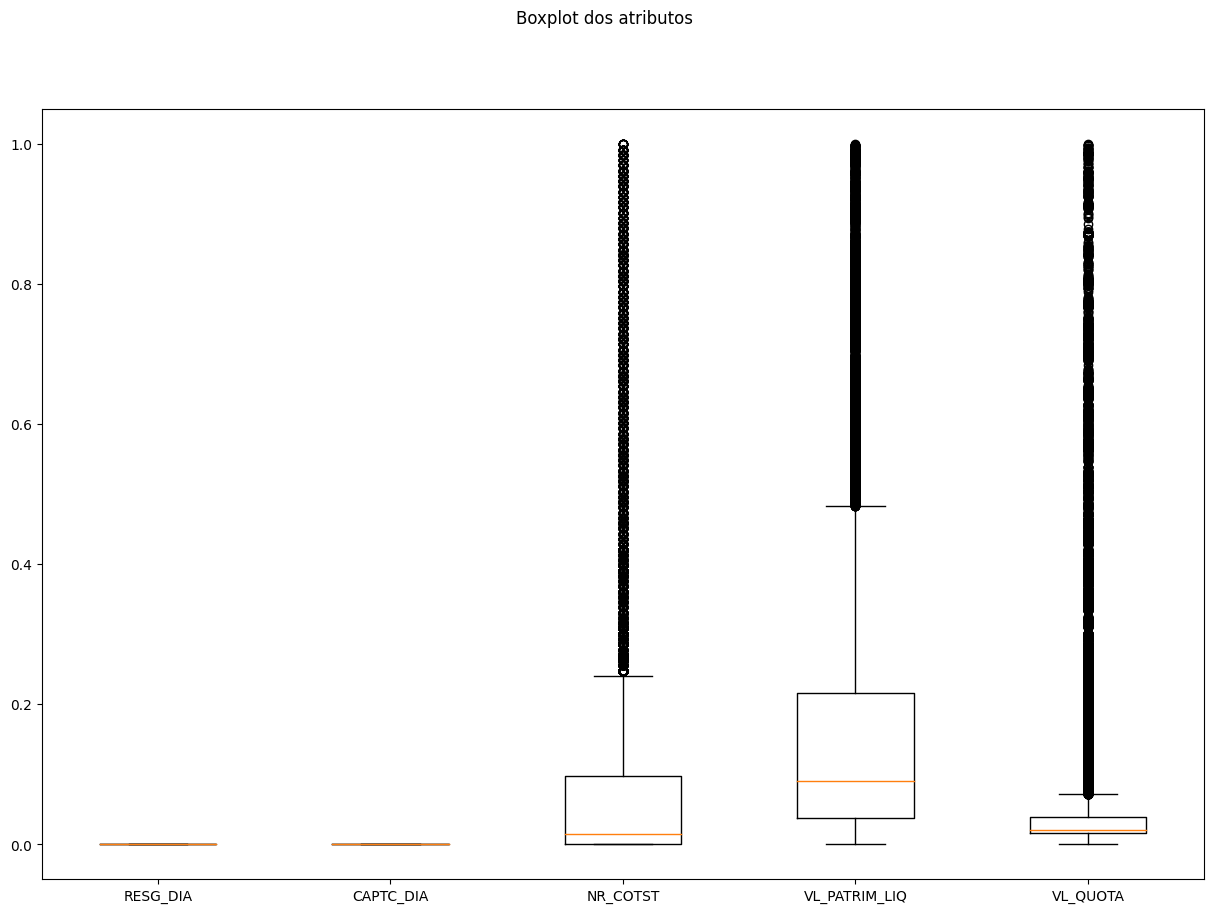

In [175]:
# Boxplot dos atributos
df_box = df_atrib[['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']]
names = ('RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA')

fig = plt.figure(figsize=(15,10))
fig.suptitle('Boxplot dos atributos')
ax = fig.add_subplot(111)
plt.boxplot(df_box)
ax.set_xticklabels(names)
plt.show()

### _Linear

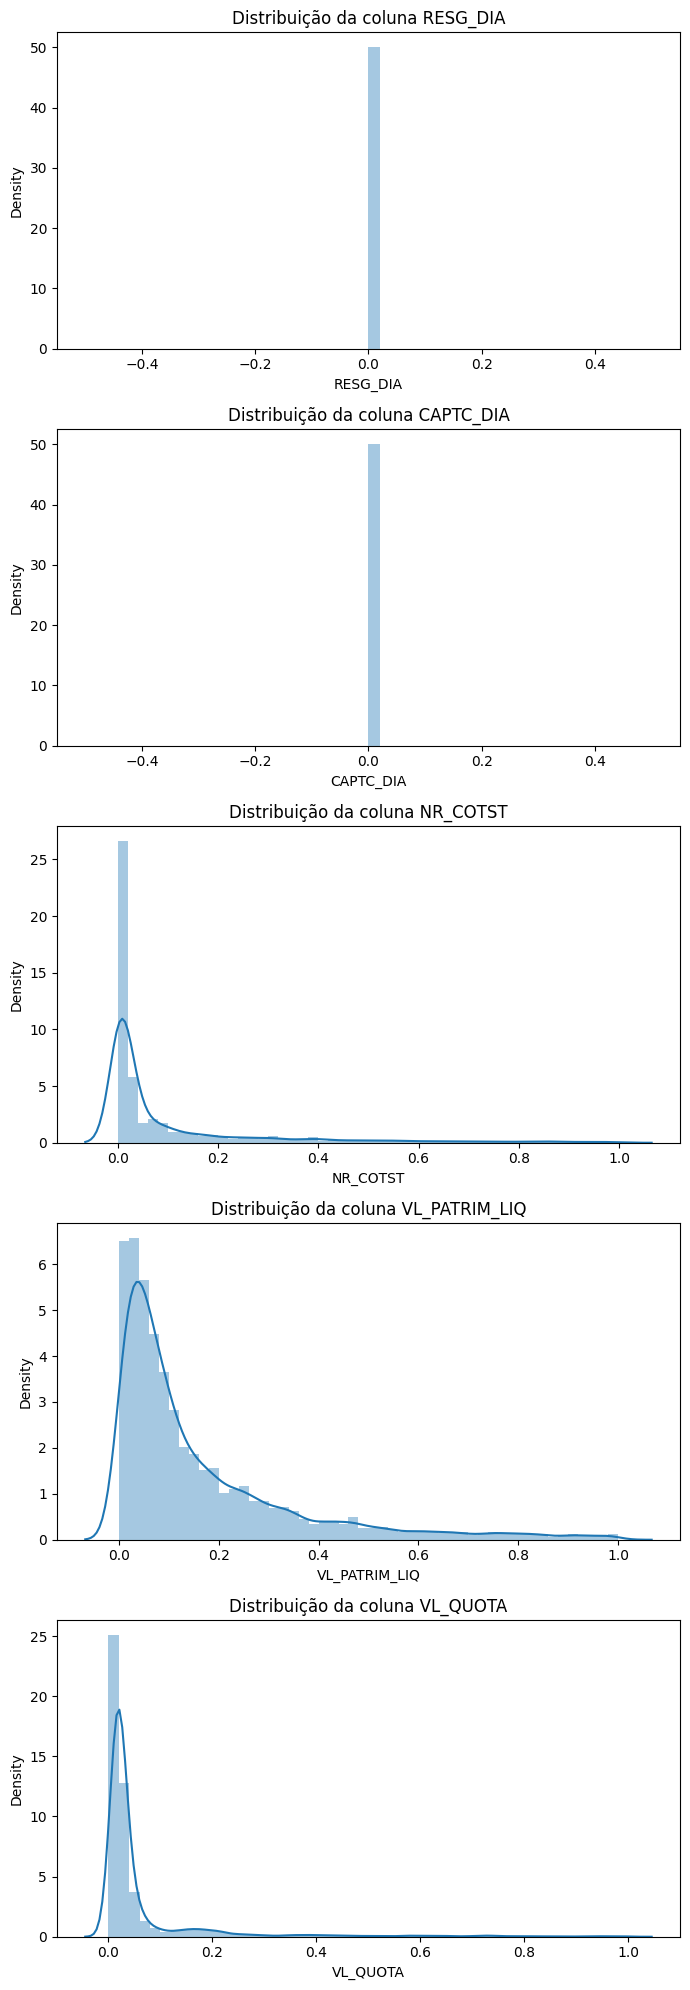

In [176]:
# Distribuíção Linear
# Lista das colunas que você deseja visualizar
cols = ['RESG_DIA', 'CAPTC_DIA', 'NR_COTST', 'VL_PATRIM_LIQ', 'VL_QUOTA']

# Cria uma figura com 5 subplots
fig, axs = plt.subplots(5, figsize=(7, 20))

# Para cada coluna, cria um gráfico de distribuição linear
for i, col in enumerate(cols):
    sns.distplot(df_atrib[col], ax=axs[i])
    axs[i].set_title('Distribuição da coluna {}'.format(col))

plt.tight_layout()
plt.show()

## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = df_3.values
X = array[:,0:8]
y = array[:,8]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

IndexError: ignored

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)